<center>
<h1>Mustererkennung und Machine Learning</h1>

<h3> Wintersemester 2017/2018, 2nd Exercise Sheet</h3>
<h4>Luis Herrmann; Dozent: Raúl Rojas</h4>

<hr style='height:1px'>
</center>

First of all, we define the functions to load the data form the specified files. Please sure to change the path for the training files for the respective path.

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def readfile(filename):
    """Opens file with given filename and reads in data line after line into a numpy array"""
    data = []
    f = open(filename)
    for line in f:
        ls = line.split(' ')
        digit = int(float(ls[0]))
        matrix = np.array([float(val) for val in ls[1:257]])
        data.append((digit,matrix))
    f.close()
    return(data)
    
def visualize(data,i):
    """For a list of numpy arrays with 256 greyscale values, visualizes the greyscale data creating a greyscale plot of the reshaped 16x16 numpy array"""
    plt.gray()
    plt.imshow(data[i][1].reshape([16,16]))
    
train = readfile('E:/Users/Tanui/Documents/Uni/info/MachineLearning/uebung1/zip.train')
test = readfile('E:/Users/Tanui/Documents/Uni/info/MachineLearning/uebung1/zip.test')

To make sure that our data makes sense, we visualize the greyscale data vector for our first data sample of the training data.

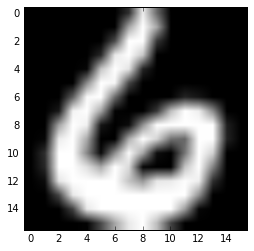

In [2]:
visualize(train,0)

Now we can get started programming a binary classifier. For this, we set up a class BinaryClassifier which is fairly straight forward: For the digits specified in the constructor, the classifier can be trained with the trainData and by calling the <font color=blue>reduce()</font>-method will only train using samples corresponding to the digits specified.

The training is as follows. Consider a binary classifier for digits $d_1$ and $d_2$. Let the training data list contain $N$ vectors $v_1,v_2, ... v_n$ of size $n = 256$. Each vector has a pre-assigned digit class $\delta_i = d_1, d_2$. For each vector $v_i$, we will assign the label:

<center>$y_i = \begin{cases}+1, &\delta_i =d_1\\-1, &\delta_i = d_2 \end{cases}$</center>

Training means that we want to determine a set of coefficients $\beta_0, \beta_1, ..., \beta_n$ such that any vector satisfies

<center>$y_i = \beta_0 + \beta_1 v_{i1} + ... + \beta_n v_{in}$</center>

So, we formulate the linear equation system as $X\vec{\beta} = \vec{y}$, where:

<center>$X = \begin{pmatrix} 1 &v_{11} &... &v_{1n}\\
1 &v_{21} &... &v_{2n}\\
\vdots &\vdots &\ddots &\vdots\\
1 &v_{N1} &... &v_{Nn}
\end{pmatrix}
\quad \vec{\beta} = (\beta_0, \beta_1, ..., \beta_n)
\quad \vec{y} = (y_0, y_1, ..., y_n)$
</center>

As derived in <a href='http://www.inf.fu-berlin.de/inst/ag-ki/rojas_home/documents/tutorials/LinearRegression.pdf'>this article</a>, one can show that even when $X$ is not invertible, the optimum solution of the above equation (which is the least squares problem) is obtained as $\beta = X^+ y$ where $X^+$ is the pseudoinverse of $X$.

In [3]:
class BinaryClassifier:
    def __init__(self, digit1, digit2, data=None):
        """Expects data and two nonequal ints betweeen 0 and 9 specifying the class of the classifier"""
        if(not(0 <= digit1 and digit1 <= 9 and 0 <= digit2 and digit2 <= 9)):
            raise Exception('The digits passed must be an int between 0 and 9!')
        if(digit1 == digit2):
            raise Exception('The digits passed must not be equal!')
        self.digit1 = digit1
        self.digit2 = digit2
        if(data != None):
            self.train(data)
        
    def train(self, trainData):
        ftrainData = self.reduce(trainData)
        #Determine dimensions of the classifier matrix (where n is the number of features) and build it:
        N, n = len(ftrainData), 256
        X = np.zeros([N,n+1])
        X[:,0] = 1
        y = np.zeros(N)
        for i in range(N):
            X[i,1:] = ftrainData[i][1]
            #Label +1 for match with digit class, -1 for no-match with digit class
            if(ftrainData[i][0] == self.digit1):
                y[i] = +1.
            else:
                y[i] = -1.
        Xp = np.linalg.pinv(X)
        self.b = np.dot(Xp,y)
    
    def reduce(self, data):
        """Keeps only data samples corresponding to the two digits of the class"""
        filteredData = []
        for sample in data:
            if(sample[0] == self.digit1 or sample[0] == self.digit2):
                filteredData.append(sample)
        return filteredData
        
    def classify(self, data):
        """
        Expects a vector of dimension 256.
        Returns:
            digit1 if classification value lies in [0.,1.] (closer to +1 than to -1)
            digit2 if classification value lies in [-1.,0.] (closer to -1 than to +1)
        """
        value = self.b[0] + np.dot(self.b[1:], data)
        if(value > 0):
            return self.digit1
        else:
            return self.digit2

With the classifier defined, we derive three different classifiers for the respective digits

In [4]:
C35 = BinaryClassifier(3, 5, train)
C37 = BinaryClassifier(3, 7, train)
C38 = BinaryClassifier(3, 8, train)
C57 = BinaryClassifier(5, 7, train)
C58 = BinaryClassifier(5, 8, train)

Finally, we defined a function runtest to run the <font color='blue'>classifer()</font>-functions of the respective classifier on the test data and obtain the confusion matrices and error rates

In [5]:
from IPython.display import display, HTML
def runtest(C):
    print('Test for Classifier for digits ' + str(C.digit1) + ' and ' + str(C.digit2) + ':')
    ftest = C.reduce(test)
    confusionMat = np.zeros([2,2], dtype=int)
    for sample in ftest:
        confusionMat[int(sample[0] != C.digit1), int(C.classify(sample[1]) != C.digit1)] += 1
    print('-The confusion matrix is given by:')
    html = pd.DataFrame(confusionMat,index=[str(C.digit1),str(C.digit2)], columns=[str(C.digit1),str(C.digit2)]).to_html()
    display(HTML(html))
    print('-The error rate is: ' + str(1-sum(np.diag(confusionMat))/len(ftest)) + '\n')

In [6]:
runtest(C35)
runtest(C37)
runtest(C38)
runtest(C57)
runtest(C58)

Test for Classifier for digits 3 and 5:
-The confusion matrix is given by:


,3,5
3,154,12
5,11,149


-The error rate is: 0.0705521472393

Test for Classifier for digits 3 and 7:
-The confusion matrix is given by:


,3,7
3,161,5
7,3,144


-The error rate is: 0.0255591054313

Test for Classifier for digits 3 and 8:
-The confusion matrix is given by:


,3,8
3,156,10
8,6,160


-The error rate is: 0.0481927710843

Test for Classifier for digits 5 and 7:
-The confusion matrix is given by:


,5,7
5,157,3
7,2,145


-The error rate is: 0.0162866449511

Test for Classifier for digits 5 and 8:
-The confusion matrix is given by:


,5,8
5,154,6
8,6,160


-The error rate is: 0.0368098159509

